# Import Libraries

In [1]:
import os # Library for accessing the file system
import cv2 # Library for image processing
from PIL import Image # Library for image processing
from IPython.display import display # Library for displaying images in Jupyter notebooks
import matplotlib.pyplot as plt # Library for data visualization
import numpy as np # Library for numerical computations
import pandas as pd # Library for data manipulation and analysis
from keras.applications import MobileNetV2 # Pre-trained CNN model
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input # Layers for building neural network
from keras.models import Model # Framework for building neural network
from keras.optimizers import Adam # Optimizer for gradient descent
from keras.preprocessing.image import ImageDataGenerator # Utility for loading images and performing data augmentation
from keras.utils import to_categorical # Utility for converting labels to categorical values
from sklearn.preprocessing import LabelEncoder # Utility for encoding labels
from sklearn.metrics import classification_report, confusion_matrix # Utility for evaluating model performance
from sklearn.model_selection import train_test_split # Utility for splitting data into training and testing sets
import seaborn as sns # Library for data visualization

# Data Analysis

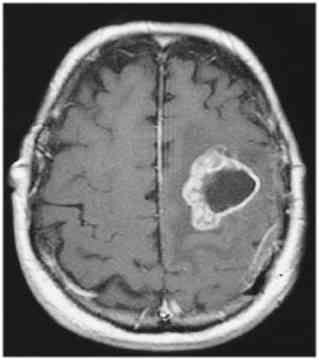

In [2]:
# Define the path to the dataset
dataset_path = "./brain_tumor_dataset"

# Open image file
img = Image.open("./brain_tumor_dataset/yes/Y10.jpg")

# Display the image
display(img)

# Data Preprocess

In [3]:
# Load the image data and labels
data = [] # initialize empty list to store image data
labels = [] # initialize empty list to store corresponding labels

# Iterate through each category in ["no", "yes"]
for category in ["no", "yes"]:
    path = os.path.join(dataset_path, category) # set the path to the directory containing the images for this category
    for img in os.listdir(path): # iterate through each image file in the directory
        img_path = os.path.join(path, img) # set the full file path for the image
        image = cv2.imread(img_path) # read the image data into a numpy array
        image = cv2.resize(image, (224, 224)) # resize the image to (224,224)
        data.append(image) # add the image data to the list of data
        labels.append(category) # add the corresponding label to the list of labels

# Print the data and labels lists
print(data)
print(labels)

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

In [4]:
# create an instance of the LabelEncoder class
le = LabelEncoder()

# transform the labels into numerical values using the fit_transform() method of the LabelEncoder object
labels = le.fit_transform(labels)

# print the resulting numerical values of the labels
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
# Convert the data and labels lists to NumPy arrays
data = np.array(data)   # convert the list 'data' to a NumPy array and store it in a variable called 'data'
labels = np.array(labels)   # convert the list 'labels' to a NumPy array and store it in a variable called 'labels'

# Print the NumPy arrays
print(data)   # print the NumPy array 'data'
print(labels)   # print the NumPy array 'labels'

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [6]:
# Perform one-hot encoding on the labels
labels = to_categorical(labels)

# Print the one-hot encoded labels
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [7]:
# Split the data using the train_test_split function and store the results in variables
(trainX, testX, trainY, testY) = train_test_split(
    data, # dataset to be split
    labels, # corresponding labels
    test_size=0.2, # 20% of the data will be used for testing and 80% for training
    stratify=labels, # ensures that the ratio of classes in the original dataset is maintained in both the training and testing datasets
    random_state=42 # sets the random seed to ensure reproducibility
)

print(trainX, testX, trainY, testY)

[[[[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  6   6   6]
   [  6   6   6]
   [  6   6   6]]

  [[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  6   6   6]
   [  6   6   6]
   [  6   6   6]]

  [[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  6   6   6]
   [  6   6   6]
   [  6   6   6]]

  ...

  [[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  6   6   6]
   [  6   6   6]
   [  6   6   6]]

  [[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  6   6   6]
   [  7   7   7]
   [  7   7   7]]

  [[  6   6   6]
   [  6   6   6]
   [  6   6   6]
   ...
   [  7   7   7]
   [  7   7   7]
   [  8   8   8]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [8]:
# Define the data augmentation object with the desired parameters
aug = ImageDataGenerator(
    rotation_range=20, # Randomly rotate the image up to 20 degrees
    zoom_range=0.15, # Randomly zoom in or out on the image by up to 15%
    width_shift_range=0.2, # Randomly shift the image horizontally by up to 20% of its width
    height_shift_range=0.2, # Randomly shift the image vertically by up to 20% of its height
    shear_range=0.15, # Randomly apply shearing transformations to the image by up to 15%
    horizontal_flip=True, # Randomly flip the image horizontally
    fill_mode="nearest" # Fill any empty pixels created during the transformation with the nearest available pixel value.
)

# Model Development

In [9]:
# Load the MobileNetV2 network with pre-trained weights
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [10]:
# Define the head of the model that will be placed on top of the base model
headModel = baseModel.output

# Add Average Pooling layer with a pool size of (7, 7) to the head model
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)

# Flatten the output of the previous layer and add a name to it
headModel = Flatten(name="flatten")(headModel)

# Add a fully connected Dense layer with 128 units and a ReLU activation function
headModel = Dense(128, activation="relu")(headModel)

# Add a Dropout layer with a rate of 0.5 to reduce overfitting
headModel = Dropout(0.5)(headModel)

# Add a fully connected Dense layer with 2 units and a softmax activation function
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# This code freezes the layers of a pre-trained base model, so that they will not be trained during fine-tuning.
# Loop through each layer in the base model
for layer in baseModel.layers:
    # Set the "trainable" attribute of the layer to False
    layer.trainable = False

In [12]:
# Initialize the hyperparameters
INIT_LR = 1e-4 # Learning rate
EPOCHS = 20 # Number of epochs
BS = 32 # Batch size

# Create a new model with baseModel as input and headModel as output
model = Model(inputs=baseModel.input, outputs=headModel)

# Define the optimizer with the specified learning rate and decay
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# Compile the model with the binary crossentropy loss function, the defined optimizer and the accuracy metric
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
# Train the model using augmented data
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS), # Augmented data generator
    steps_per_epoch=len(trainX) // BS, # Number of batches per epoch
    validation_data=(testX, testY), # Validation data
    validation_steps=len(testX) // BS, # Number of batches for validation
    epochs=EPOCHS # Number of training epochs
)

Epoch 1/20
6/6 [==============================] - 18s 2s/step - loss: 0.7860 - accuracy: 0.6146 - val_loss: 0.6904 - val_accuracy: 0.6471
Epoch 2/20
6/6 [==============================] - 6s 915ms/step - loss: 0.7934 - accuracy: 0.5882 - val_loss: 0.6711 - val_accuracy: 0.6078
Epoch 3/20
6/6 [==============================] - 6s 908ms/step - loss: 0.7670 - accuracy: 0.6059 - val_loss: 0.6509 - val_accuracy: 0.6667
Epoch 4/20
6/6 [==============================] - 6s 988ms/step - loss: 0.8130 - accuracy: 0.5052 - val_loss: 0.6372 - val_accuracy: 0.7059
Epoch 5/20
6/6 [==============================] - 6s 910ms/step - loss: 0.7357 - accuracy: 0.6588 - val_loss: 0.6210 - val_accuracy: 0.7255
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.7170 - accuracy: 0.5941 - val_loss: 0.6032 - val_accuracy: 0.7255
Epoch 7/20
6/6 [==============================] - 6s 931ms/step - loss: 0.7376 - accuracy: 0.6118 - val_loss: 0.5894 - val_accuracy: 0.7255
Epoch 8/20
6/6 [=========

In [14]:
# Make predictions on the test set
predictions = model.predict(testX)

# Convert the predicted probabilities to class labels
predictions = np.argmax(predictions, axis=1)

# Generate a classification report
report_dict = classification_report(testY.argmax(axis=1), predictions, target_names=le.classes_, output_dict=True)

# create a pandas DataFrame from the classification report dictionary
df = pd.DataFrame(report_dict)

print(df)

# save the DataFrame to a CSV file
df.to_csv('MNV2_Report.csv')

# Save the model
model.save("MNV2_Model.h5")

2/2 [==============================] - 3s 302ms/step
                  no        yes  accuracy  macro avg  weighted avg
precision   0.941176   0.882353  0.901961   0.911765      0.905421
recall      0.800000   0.967742  0.901961   0.883871      0.901961
f1-score    0.864865   0.923077  0.901961   0.893971      0.900249
support    20.000000  31.000000  0.901961  51.000000     51.000000


# Result Analysis

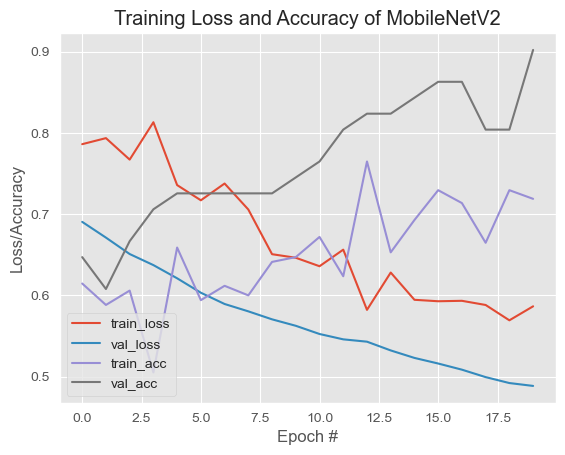

In [15]:
# This code plots the training loss and accuracy of the MobileNetV2 model.
# It uses the "ggplot" style for the plot.

# Set the style of the plot
plt.style.use("ggplot")

# Create a new figure
plt.figure()

# Add four plots to the figure: training loss, validation loss, training accuracy, and validation accuracy
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

# Set the title of the plot
plt.title("Training Loss and Accuracy of MobileNetV2")

# Add labels to the x and y axes of the plot
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

# Add a legend to the plot in the lower left corner
plt.legend(loc="lower left")

# Save the plot as an image file
plt.savefig('MNV2_Loss_Accuracy.png')

# Display the plot on the screen
plt.show()

2/2 [==============================] - 1s 275ms/step


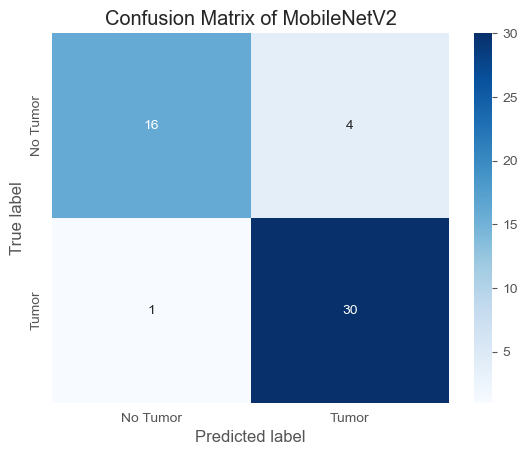

In [16]:
# This code plots the Confusion Matrix of the MobileNetV2 model.

# First, get the true and predicted labels
y_true = np.argmax(testY, axis=1)
y_pred = np.argmax(model.predict(testX), axis=1)

# Then, get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['No Tumor', 'Tumor']

# Create a heatmap using the confusion matrix, with annotations and blue color scheme
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels and title to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix of MobileNetV2')

# Save the plot as an image file
plt.savefig('MNV2_Confusion_Matrix.png')

# Display the plot
plt.show()